In [ ]:
import pandas as pd
#https://www.data.gouv.fr/datasets/demandes-de-valeurs-foncieres/#/resources/d573456c-76eb-4276-b91c-e6b9c89d6656
df = pd.read_csv("./ValeursFoncieres-2025-S1_mini.txt", sep='|', on_bad_lines='skip')

In [ ]:
#data overview
df.head()
#list(df.columns)
print(df['Code departement'].value_counts())
#df.describe()
#df['Section'].describe()

In [ ]:
#filter the lines of interest
df = df[(
            (df['Type local'] == 'Appartement')
            #& (df['Commune'] == 'NICE')
            & (df['Nature mutation'] == 'Vente')
            #& (df['Code departement'] != '2A')
            #& (df['Code departement'] != '2B')
        )]
df.head()

In [ ]:
#drop the columns not used
exclusions = [
        'Identifiant de document',
        'Reference document',
        '1 Articles CGI',
        '2 Articles CGI',
        '3 Articles CGI',
        '4 Articles CGI',
        '5 Articles CGI',
        'No disposition',
        'Date mutation',
        'Nature mutation',
        #'Valeur fonciere',
        'No voie',
        'B/T/Q',
        'Type de voie',
        'Code voie',
        'Voie',
        'Code postal',
        #'Commune',
        #'Code departement',
        'Code commune',
        'Prefixe de section',
        #'Section',
        'No plan',
        'No Volume',
        '1er lot',
        'Surface Carrez du 1er lot',
        '2eme lot',
        'Surface Carrez du 2eme lot',
        '3eme lot',
        'Surface Carrez du 3eme lot',
        '4eme lot',
        'Surface Carrez du 4eme lot',
        '5eme lot',
        'Surface Carrez du 5eme lot',
        #'Nombre de lots',
        'Code type local',
        'Type local',
        'Identifiant local',
        #'Surface reelle bati',
        #'Nombre pieces principales',
        'Nature culture',
        'Nature culture speciale',
        'Surface terrain'
]
df = df.drop(columns=exclusions)
df.head()

In [36]:
#remove the lines having NaN
df.dropna(inplace=True)
df.head()

,Valeur fonciere,Commune,Code departement,Section,Nombre de lots,Surface reelle bati,Nombre pieces principales
5,180000.0,MONTANGES,1,AC,0,87.0,4.0
20,183000.0,GEX,1,AH,1,35.0,2.0
27,131937.3,AMBERIEUX-EN-DOMBES,1,AC,1,49.0,2.0
29,173000.0,PONT-DE-VEYLE,1,A,1,78.0,3.0
50,414665.0,CHALLEX,1,B,2,67.0,3.0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

In [ ]:
#frequency based embedding (vs prediction based embedding)

#count vector encoding
#large vocabulary > large features vectors
#undordered, loss semantic
#mitigation: can filter on top N/ hashing for bucketing
#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(df_encoded['Commune'])

#TD-IDF
#vectorizer = TfidfVectorizer()
df['Section'] = df['Section'].astype('category')
#df['Date mutation'] = pd.to_datetime(df['Date mutation'],format='%m/%d/%Y', errors='coerce')
#df['Date mutation']=df['Date mutation'].astype(int) #unix timestamp
df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(',', '.').astype(float)
#df['Surface Carrez du 1er lot'] = df['Surface Carrez du 1er lot'].str.replace(',', '.').astype(float)
df['Code departement'] = df['Code departement'].replace({'2A': 2001, '2B': 2002})
df['Code departement'] = df['Code departement'].astype(int)

In [ ]:
#dataset sanity checks
print(df[df.isna().any(axis=1)])

In [ ]:
#dataset sanity checks
print(df.select_dtypes(include='object'))
#print(df.select_dtypes(include='object').columns)

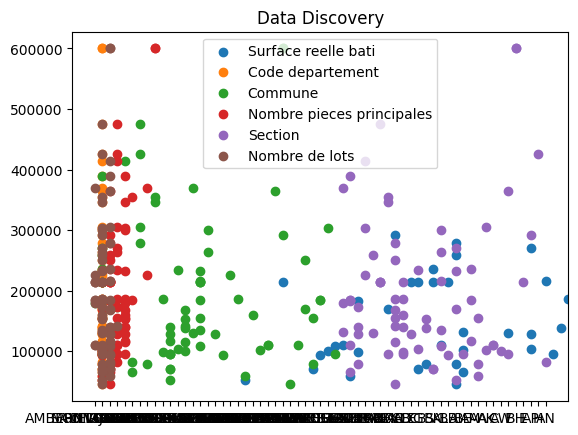

In [37]:
import matplotlib.pyplot as plt
plt.scatter(df['Surface reelle bati'], df['Valeur fonciere'], label='Surface reelle bati')
plt.scatter(df['Code departement'], df['Valeur fonciere'], label='Code departement')
plt.scatter(df['Commune'], df['Valeur fonciere'], label='Commune')
plt.scatter(df['Nombre pieces principales'], df['Valeur fonciere'], label='Nombre pieces principales')
plt.scatter(df['Section'], df['Valeur fonciere'], label='Section')
plt.scatter(df['Nombre de lots'], df['Valeur fonciere'], label='Nombre de lots')
plt.title('Data Discovery')
plt.legend()
plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf1', TfidfVectorizer(), 'Commune'),
        ('onehot1', OneHotEncoder(sparse_output=False, dtype=int), ['Section']),
    ],
    remainder='passthrough'  # Keep all other columns
)

df_x = df.drop(['Valeur fonciere'], axis=1)

X = preprocessor.fit_transform(df_x)
predictors = preprocessor.get_feature_names_out()
print(predictors)

Y=df['Valeur fonciere']

X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
#https://medium.com/@shanu9494/simple-linear-regression-using-rmse-as-cost-function-d5731da8dfa0
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
linear_model.score(X_train, Y_train)

0.9752703239659692

In [ ]:
linear_model.coef_
coef = pd.Series(linear_model.coef_, predictors).sort_values()
print(coef)

In [ ]:
y_predict=linear_model.predict(x_test)

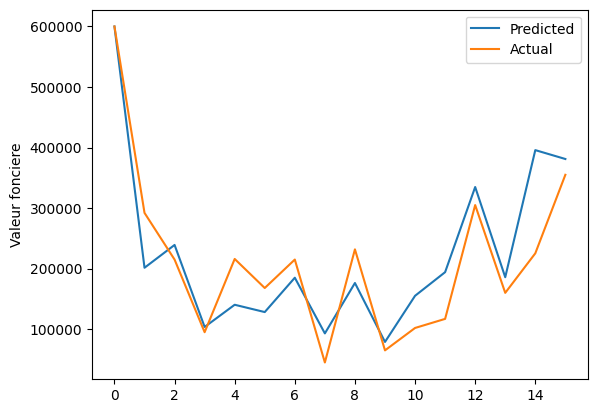

In [33]:
plt.plot(y_predict, label='Predicted')
plt.plot(y_test.values, label='Actual')
plt.ylabel('Valeur fonciere')

plt.legend()
plt.show()

In [35]:
r_square = linear_model.score(x_test, y_test)
r_square

0.7723406690910208